In [1]:
from fbm_dropout.net import DenseNet, DenseNetFBM
import torch.optim as optim
import torch.nn as nn

hidden_sizes = [1024, 1024]
grid_sizes = [(28, 28), (32, 32)]
n_agents = [0, 60]
device='cuda'

model = DenseNet(hidden_sizes, [0, 0], device=device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

model_dropout = DenseNet(hidden_sizes, [0, .2], device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.001)

model_fbm_dropout = DenseNetFBM(hidden_sizes, n_agents, 50, 350, 10, grid_sizes, device=device)
optimizer_fbm_dropout = optim.SGD(model_fbm_dropout.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [2]:
import torch
from fbm_dropout.dataset import get_MNIST_dataset

trainset, testset = get_MNIST_dataset('~/dataset')
idx = torch.randint(0, 60000, (20000,)).tolist()
trainset = torch.utils.data.Subset(trainset, idx)
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [3]:
results = {}
results['train loss'] = {}
results['train loss']['no dropout'] = []
results['train loss']['dropout'] = []
results['train loss']['fbm dropout'] = []

results['test loss'] = {}
results['test loss']['no dropout'] = []
results['test loss']['dropout'] = []
results['test loss']['fbm dropout'] = []

results['test acc'] = {}
results['test acc']['no dropout'] = []
results['test acc']['dropout'] = []
results['test acc']['fbm dropout'] = []

results['num wrong'] = {}
results['num wrong']['no dropout'] = []
results['num wrong']['dropout'] = []
results['num wrong']['fbm dropout'] = []

for epoch in range(100):
    model.train()
    model_dropout.train()
    model_fbm_dropout.train()

    running_loss = {}
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        optimizer_dropout.zero_grad()
        optimizer_fbm_dropout.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss['no dropout'] += loss.item()

        output_dropout = model_dropout(images)
        loss_dropout = criterion(output_dropout, labels)
        loss_dropout.backward()
        optimizer_dropout.step()
        running_loss['dropout'] += loss_dropout.item()

        output_fbm_dropout = model_fbm_dropout(images)
        loss_fbm_dropout = criterion(output_fbm_dropout, labels)
        loss_fbm_dropout.backward()
        optimizer_fbm_dropout.step()
        running_loss['fbm dropout'] += loss_fbm_dropout.item()

    results['train loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['train loss']['dropout'].append(running_loss['dropout'] / len(train_loader))
    results['train loss']['fbm dropout'].append(running_loss['fbm dropout'] / len(train_loader))

    model.eval()
    model_dropout.eval()
    model_fbm_dropout.eval()
    acc = acc_dropout = acc_fbm_dropout = 0.0
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    results['num wrong']['no dropout'].append(0)
    results['num wrong']['dropout'].append(0)
    results['num wrong']['fbm dropout'].append(0)
    for images, labels in test_loader:
        images = images.view(-1,784).to(device)
        labels = labels.to(device)
        output = model(images)
        _, pred = torch.max(output, axis=1)
        acc += torch.sum(pred==labels).item()
        running_loss['no dropout'] += criterion(output, labels).item()
        results['num wrong']['no dropout'][-1] += torch.sum(pred!=labels).item()
    

        output_dropout = model_dropout(images)
        _, pred_dropout = torch.max(output_dropout, axis=1)
        acc_dropout += torch.sum(pred_dropout==labels).item()
        running_loss['dropout'] += criterion(output_dropout, labels).item()
        results['num wrong']['dropout'][-1] += torch.sum(pred_dropout!=labels).item()
    
        output_fbm_dropout = model_fbm_dropout(images)
        _, pred_fbm_dropout = torch.max(output_fbm_dropout, axis=1)
        acc_fbm_dropout += torch.sum(pred_fbm_dropout==labels).item()
        running_loss['fbm dropout'] += criterion(output_fbm_dropout, labels).item()
        results['num wrong']['fbm dropout'][-1] += torch.sum(pred_fbm_dropout!=labels).item()
        
    results['test loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['test loss']['dropout'].append(running_loss['dropout'] / len(train_loader))
    results['test loss']['fbm dropout'].append(running_loss['fbm dropout'] / len(train_loader))
    
    results['test acc']['no dropout'].append(acc / len(testset))
    results['test acc']['dropout'].append(acc_dropout / len(testset))
    results['test acc']['fbm dropout'].append(acc_fbm_dropout / len(testset))

    model_fbm_dropout.dropout_1.branch_off()
    model_fbm_dropout.dropout_2.branch_off()
    model_fbm_dropout.dropout_3.branch_off()
    
    print('Epoch {}'.format(epoch))
    print('No Dropout : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['no dropout'][-1], results['test acc']['no dropout'][-1]))
    print('Dropout    : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['dropout'][-1], results['test acc']['dropout'][-1]))
    print('FBM Dropout: Train Loss {:.4f}, Test Acc {:.4f}, Drop Rate {:.4f} {:.4f} {:.4f}'.format(results['train loss']['fbm dropout'][-1], 
                                                                                        results['test acc']['fbm dropout'][-1], 
                                                                                        model_fbm_dropout.dropout_1.cum_dropout_rate, 
                                                                                        model_fbm_dropout.dropout_2.cum_dropout_rate,
                                                                                        model_fbm_dropout.dropout_3.cum_dropout_rate))

Epoch 0
No Dropout : Train Loss 2.2462, Test Acc 0.3582
Dropout    : Train Loss 2.2507, Test Acc 0.3701
FBM Dropout: Train Loss 2.2489, Test Acc 0.4194, Drop Rate 0.0000 0.2070 0.2088
Epoch 1
No Dropout : Train Loss 2.1199, Test Acc 0.5830
Dropout    : Train Loss 2.1374, Test Acc 0.5552
FBM Dropout: Train Loss 2.1341, Test Acc 0.5800, Drop Rate 0.0000 0.2063 0.2087
Epoch 2
No Dropout : Train Loss 1.9698, Test Acc 0.6937
Dropout    : Train Loss 1.9964, Test Acc 0.6698
FBM Dropout: Train Loss 1.9946, Test Acc 0.6903, Drop Rate 0.0000 0.2068 0.2100
Epoch 3
No Dropout : Train Loss 1.7819, Test Acc 0.7244
Dropout    : Train Loss 1.8156, Test Acc 0.7105
FBM Dropout: Train Loss 1.8134, Test Acc 0.7197, Drop Rate 0.0000 0.2066 0.2102
Epoch 4
No Dropout : Train Loss 1.5633, Test Acc 0.7674
Dropout    : Train Loss 1.6070, Test Acc 0.7567
FBM Dropout: Train Loss 1.6040, Test Acc 0.7742, Drop Rate 0.0000 0.2065 0.2100
Epoch 5
No Dropout : Train Loss 1.3436, Test Acc 0.7721
Dropout    : Train Loss 

In [4]:
import numpy as np

np.save('train_loss_no_dropout', results['train loss']['no dropout'])
np.save('train_loss_dropout', results['train loss']['dropout'])
np.save('train_loss_fbm_dropout', results['train loss']['fbm dropout'])

np.save('test_loss_no_dropout', results['test loss']['no dropout'])
np.save('test_loss_dropout', results['test loss']['dropout'])
np.save('test_loss_fbm_dropout', results['test loss']['fbm dropout'])

np.save('test_acc_no_dropout', results['test acc']['no dropout'])
np.save('test_acc_dropout', results['test acc']['dropout'])
np.save('test_acc_fbm_dropout', results['test acc']['fbm dropout'])

np.save('num_wrong_no_dropout', results['num wrong']['no dropout'])
np.save('num_wrong_dropout', results['num wrong']['dropout'])
np.save('num_wrong_fbm_dropout', results['num wrong']['fbm dropout'])

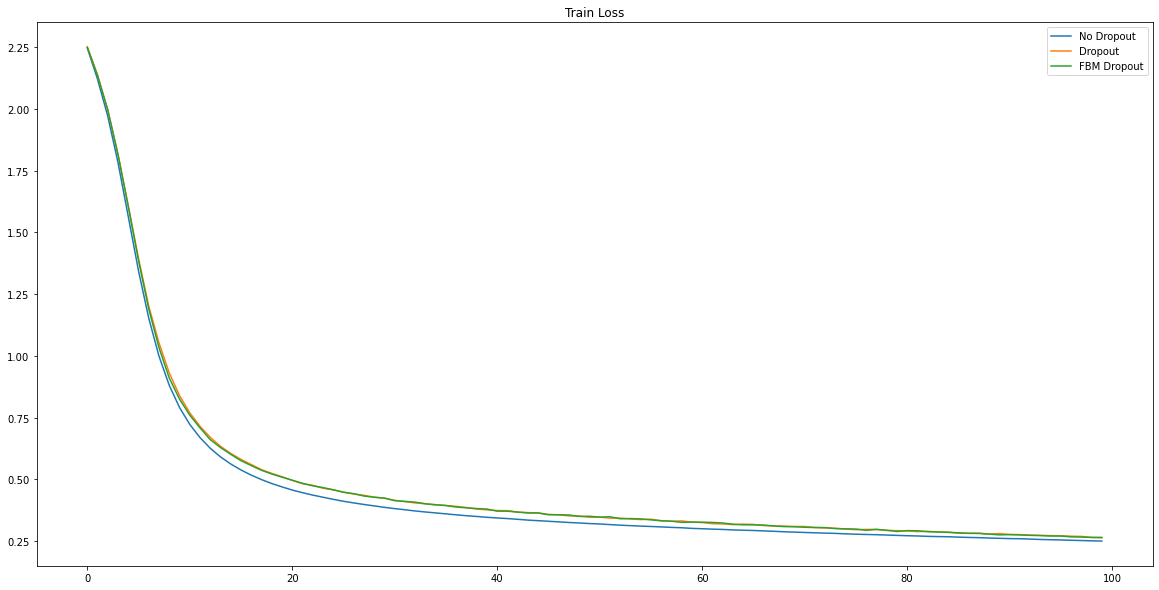

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(results['train loss']['no dropout'], label='No Dropout')
plt.plot(results['train loss']['dropout'], label='Dropout')
plt.plot(results['train loss']['fbm dropout'], label='FBM Dropout')
plt.title('Train Loss')
plt.legend()
plt.show()

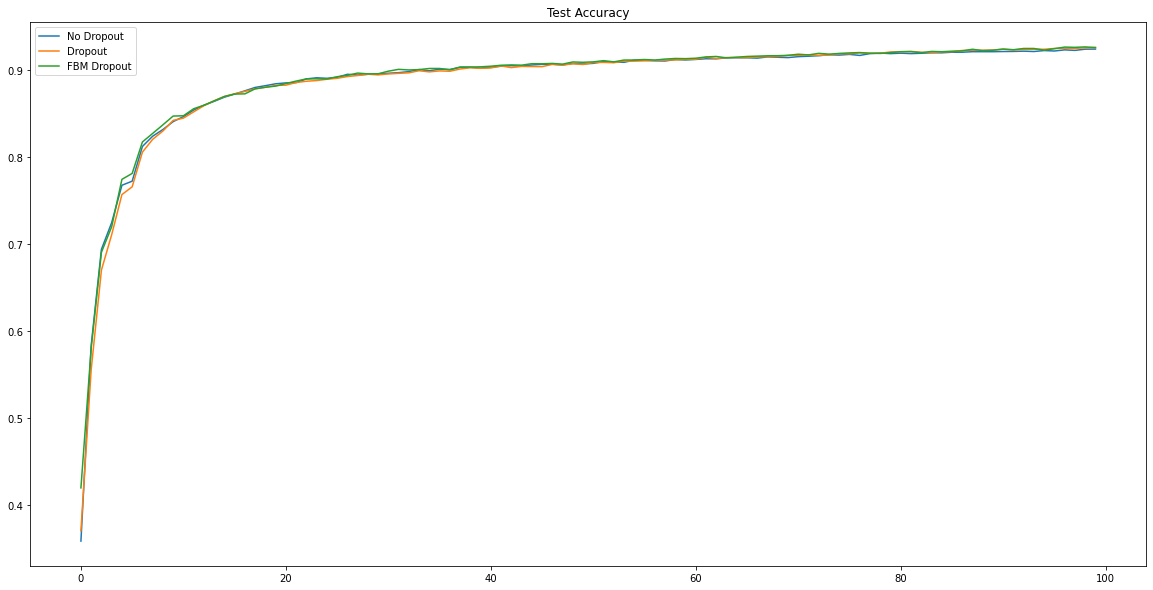

In [6]:
plt.figure(figsize=(20,10))
plt.plot(results['test acc']['no dropout'], label='No Dropout')
plt.plot(results['test acc']['dropout'], label='Dropout')
plt.plot(results['test acc']['fbm dropout'], label='FBM Dropout')
plt.title('Test Accuracy')
plt.legend()
plt.show()

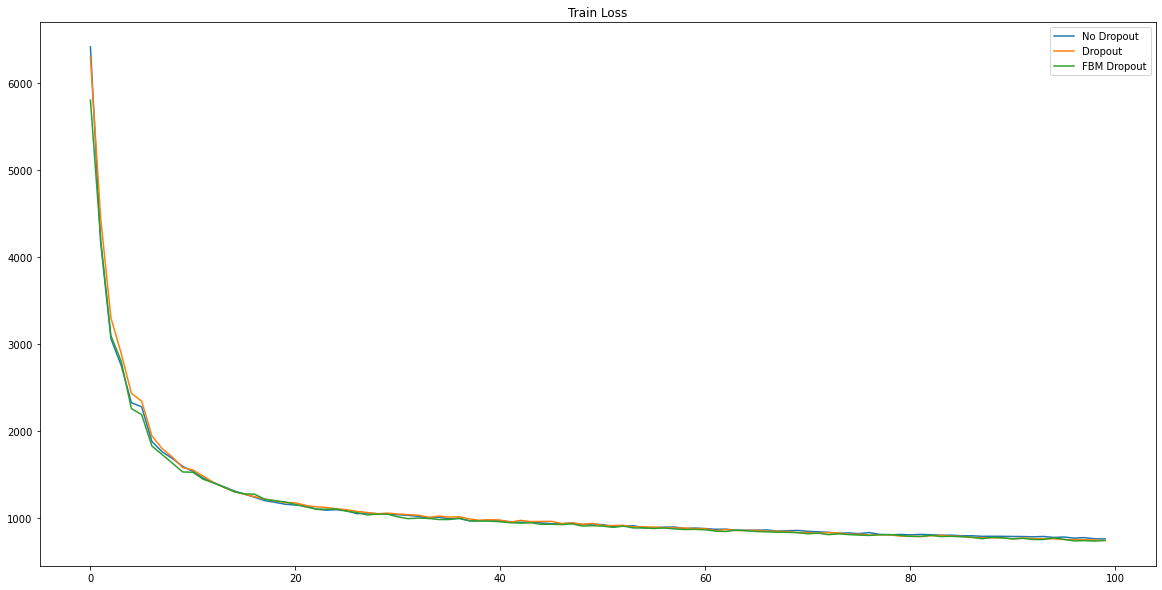

In [10]:
plt.figure(figsize=(20,10))
plt.plot(results['num wrong']['no dropout'], label='No Dropout')
plt.plot(results['num wrong']['dropout'], label='Dropout')
plt.plot([10000 - x for x in results['num wrong']['fbm dropout']], label='FBM Dropout')
plt.title('Train Loss')
plt.legend()
plt.show()

In [11]:
results['num wrong']['no dropout'][-1]

760

In [12]:
results['num wrong']['dropout'][-1]

741

In [14]:
10000 - results['num wrong']['fbm dropout'][-1]

743